## Описание проекта

**Название проекта**  

Создание RAG - системы для туризма
_____

**Цель исследования**  

Разработка и оценка качества системы ответа на вопросы на основе подхода RAG, применяемой к туристической информации о городах России
_______
**Задачи исследования**

- Анализ и очистка датасета, содержащего туристические объекты и их описание по различным городам.
- Анализ кластеризации контекста
- Формирование и индексация базы знаний с помощью векторной базы и извлечение релевантных чанк-контекстов.
- Формирование prompt-шаблонов в требуемом формате  для генерации ответов с помощью LLM.
- Использование модели LLM для генерации ответов на основе извлечённого контекста.
- Визуализация эмбеддингов чанк-контекстов с помощью PCA и UMAP.
- Оценка качества модели RAG на основе метрики Answer Relevancy

_____
**Исходные данные**  

Имеется набор данных (на русском языке), содержащий информацию о памятниках, архитектуре и других значимых местах:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание, извлеченное из WikiData;
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания (на английском языке).


## Загрузка и подготовка данных

### Установка и импорт библиотек

In [ ]:
pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn matplotlib plotly sentencepiece pymorphy2

In [ ]:
!pip install langchain-chroma -q

In [ ]:
import gdown
import os
import warnings
import umap
import plotly.express as px
import random
import pandas as pd
import numpy as np
import base64
import requests
import matplotlib.pyplot as plt
import PIL
import re
import string
import nltk
import pymorphy2
import torch

from tqdm.notebook import tqdm
from typing import Optional, List, Tuple, Union
from PIL import Image
from io import BytesIO
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from ragatouille import RAGPretrainedModel
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
nltk.download('stopwords')

2025-06-08 07:01:22.249007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366082.271853    3996 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366082.278774    3996 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_3996/1927177322.py:36: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However

True

### Объявление функций

In [ ]:
def seed_torch(seed:int=42):
    """
    Функция для фиксации воспроизведения расчетов
        seed:int - параметр фиксации
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
def get_image(data):
    """
    Преобразует base64-закодированную строку в объект изображения PIL в RGB формате.
    """
    image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
    return image

In [ ]:
SEED = 42
seed_torch(SEED)

### Загрузка данных

In [ ]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

try:
   gdown.download(url, output, quiet=False)
   print(f"Файл успешно загружен как {output}")
except Exception as e:
   print(f"Ошибка при загрузке файла: {e}")

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=697b2244-bf2e-46bf-8412-93730d3228d4
To: /kaggle/working/file.csv
100%|██████████| 672M/672M [00:03<00:00, 213MB/s]  


Файл успешно загружен как file.csv


In [ ]:
data_orig = pd.read_csv('file.csv')
print(data_orig.shape)
data_orig.head(3)

(14634, 9)


,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...


Пример изображения

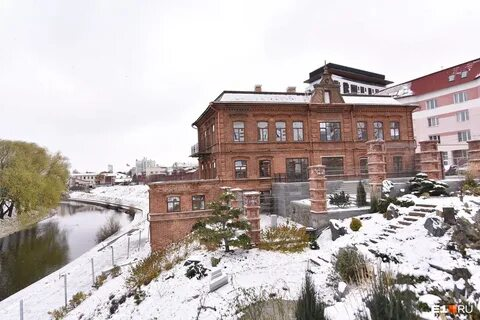

In [ ]:
get_image(data_orig.sample(1)['image'].tolist()[0])

## Анализ, фильтрация и очистка данных

### Анализ данных

In [ ]:
need_cols = ['Name', 'City', 'description', 'image', 'en_txt']
data_orig = data_orig[need_cols]
print(data_orig.shape)
data_orig.head()

(14634, 5)


,Name,City,description,image,en_txt
0,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


In [ ]:
display(data_orig.nunique(), data_orig.describe())

Name             387
City               4
description      245
image          13281
en_txt         10154
dtype: int64

,Name,City,description,image,en_txt
count,14634,14634,12078,14634,14634
unique,387,4,245,13281,10154
top,Владимир,Ярославль,Православный храм в Ярославле,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAICAgICAQICAg...,arafed view of a large white building with gol...
freq,114,4372,605,10,83


Сгруппируем данные по уникальной достопримечательности в конкретном городе. По каждой группе собирем множество изображений и описаний изображения.

In [ ]:
data = data_orig.groupby(['Name', 'City', 'description']).agg({'image': set, 'en_txt': set}).reset_index()
print(data.shape)
data.head(5)

(320, 5)


,Name,City,description,image,en_txt
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small white and orange building wi...
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large wooden church with a steeple...
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large church with a steeple on the...
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{painting of a city with a church and a steepl...
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large building with a clock tower ...


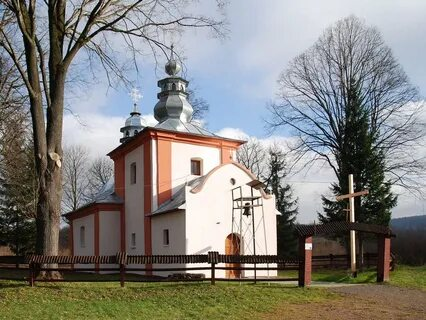

In [ ]:
get_image(list(data['image'][0])[0])

In [ ]:
list(data['en_txt'][0])

['there is a small white and orange building with two towers',
 'arafed wooden church with a steeple and a blue roof',
 'arafed wooden buildings with a steeple and a fence',
 'there is a small wooden building with a steeple on top',
 'arafed wooden building with a steeple and a cross on the top',
 'there is a wooden structure with a steeple on top of it',
 'there is a wooden building with a wooden fence and a wooden fence',
 'there are two wooden buildings in the middle of a field',
 'there is a wooden building with a steeple on the top',
 'arafed view of a white building with a green dome',
 'arafed wooden church with steeple and steeple on top',
 'there is a small church with a steeple on the top of it',
 'arafed wooden building with a steeple and a steeple on the top',
 'arafed wooden church with a steeple and a steeple on the roof',
 'arafed wooden church with steeple and steeple on the front',
 'there is a wooden church with two steeples on top of it',
 'arafed wooden building wit

In [ ]:
# Самые часто встречающиеся описания
data.groupby('description').Name.count().sort_values(ascending=False).reset_index().head()

,description,Name
0,Православный храм в Ярославле,13
1,здание в Екатеринбурге,10
2,музей в Екатеринбурге,8
3,круглая башня Нижегородского кремля,8
4,памятник в Екатеринбурге,4


In [ ]:
print(f'Количество уникальных городов: {data.City.nunique()}')
data.City.value_counts()

Количество уникальных городов: 4


City
Нижний Новгород    98
Екатеринбург       97
Ярославль          96
Владимир           29
Name: count, dtype: int64

In [ ]:
# Проверим доли пропущенных значений
data.isna().mean()

Name           0.0
City           0.0
description    0.0
image          0.0
en_txt         0.0
dtype: float64

In [ ]:
# оценка длин содержимого по столбцам
for i in need_cols:
    data[f'len_{i}'] = data[i].apply(lambda x: len(str(x)))
display(data.describe())

,len_Name,len_City,len_description,len_image,len_en_txt
count,320.000000,320.000000,320.000000,3.200000e+02,320.000000
mean,26.537500,11.656250,33.290625,1.714635e+06,2039.503125
std,12.935765,2.609476,21.594436,5.490707e+05,658.010552
min,4.000000,8.000000,5.000000,9.640800e+05,991.000000
25%,18.000000,9.000000,22.000000,1.307805e+06,1621.750000
50%,25.000000,12.000000,29.000000,1.510466e+06,1755.500000
75%,32.000000,15.000000,38.000000,1.989991e+06,2448.750000
max,76.000000,15.000000,225.000000,3.320324e+06,3785.000000


### Перевод данных

Реализуем перевод текста с русского языка на английский с использованием предобученной модели `facebook/mbart-large-50-many-to-many-mmt`

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Загрузка предтренировочной модели для машинного перевода

MODEL_TRANS_NAME = "facebook/mbart-large-50-many-to-many-mmt"
SRC_LANG = "ru_RU"
TRG_LANG = "en_XX"

# Функция для перевода текста
def translate(model_trans,
              tokenizer_trans,
              text:str,
              src:str=SRC_LANG,
              dest:str=TRG_LANG):
    """
    Функция для перевода текста
        model_trans - предобученная модель машинного перевода
        tokenizer_trans - токенизатор модели
        text:str - текст для перевода
        src:str - код языка с которого необходимо перевести
        dest:str - код языка на который необходимо перевести
    """
    # токенизация
    tokenizer_trans.src_lang = src
    encoded_input = tokenizer_trans(text, return_tensors="pt").to(DEVICE)

    # генерирация перевода
    generated_tokens = model_trans.generate(**encoded_input, forced_bos_token_id=tokenizer_trans.lang_code_to_id[dest])

    return tokenizer_trans.batch_decode(generated_tokens, skip_special_tokens=True)[0]

# Загрузка модели и токенизатора
try:
    MODEL_TRANS = MBartForConditionalGeneration.from_pretrained(MODEL_TRANS_NAME).to(DEVICE)
    TOKENIZER_TRANS = MBart50TokenizerFast.from_pretrained(MODEL_TRANS_NAME)
    print(f"Модель и токенизатор загружены успешно!")
except Exception as e:
    print(f"Ошибка при загрузке: {e}")

Модель и токенизатор загружены успешно!


In [ ]:
# Проверка кода
source_text = data['description'][0]
translated_text = translate(MODEL_TRANS, TOKENIZER_TRANS, source_text)
print(f'На русском: {source_text} \nНа английском: {translated_text}')

На русском: Православный храм в Ярославле 
На английском: Orthodox Church in Yaroslavl


Переведем все описания с русского на английский, исключая дубликаты

In [ ]:
%%time

ru_corpus = set(data.description)
trans_ru_to_en = {k:v for k, v in zip(ru_corpus, [translate(model_trans=MODEL_TRANS,
                                                            tokenizer_trans=TOKENIZER_TRANS,
                                                            text=x) for i, x in tqdm(enumerate(ru_corpus))])}
data['en_description'] = data['description'].map(trans_ru_to_en)

0it [00:00, ?it/s]

CPU times: user 55 s, sys: 58.3 ms, total: 55 s
Wall time: 54.9 s


In [ ]:
need_cols = ['Name', 'City', 'description', 'image', 'en_txt', 'en_description']
data_filterd = data[need_cols].copy()
print(data_filterd.shape)
data_filterd.head()

(320, 6)


,Name,City,description,image,en_txt,en_description
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small white and orange building wi...,Orthodox Church in Yaroslavl
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large wooden church with a steeple...,Architectural ensemble in Yaroslavl
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large church with a steeple on the...,Church of St. Demetrius of Alexandria (Smolens...
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{painting of a city with a church and a steepl...,"Armenian Church in Vladimir, Russia"
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,{/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large building with a clock tower ...,Vladimir Aviation Mechanical College


### Очистка и лемматизация данных

Предобработка текста с использованием токенизации, очистки, нормализации, удаления стоп-слов и выделения уникальных слов

In [ ]:
# Создание списков стоп-слов
ENG_STOP_WORDS = list(set(stopwords.words('english')))
RUS_STOP_WORDS = list(set(stopwords.words('russian')))
STOP_WORDS = ENG_STOP_WORDS + RUS_STOP_WORDS
STOP_WORDS.append('none')

PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer()
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()

def preprocess_text(text, norm_tokens: bool=True, stopwords: set=(), del_ru: bool=True):
    """
    Функция предобработки текста
        text - входной текст
        norm_tokens - флаг нормализации текста
        stopwords - стоп-слова
        del_ru - необходимость удалять русские слова или наоборот
    """
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())

    if del_ru:
        word_filtered_text = re.sub(r'[^a-zA-Z\s]+', '', nums_filtered_text)
    else:
        word_filtered_text = re.sub(r'[a-zA-Z]+', '', nums_filtered_text)

    # Удаление пунктуации
    punct_filtered_text = ''.join([ch for ch in word_filtered_text if ch
                                   not in string.punctuation])

    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)

    # Удаление стоп-слов + лемматизация
    if norm_tokens:
        tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens]

    if stopwords:
        tokens = [token for token in tokens if token not in stopwords]

    return ' '.join(tokens)


def unique_words(text):
    """
    Функция формирования строк из уникальных слов
        text - текст
    """
    words = text.split()
    unique_words = list(set(words))
    return ' '.join(unique_words)

Добавляем в датафрейм дополнительные колонки (фичи)

In [ ]:
data_filterd['image'] = data_filterd.image.apply(lambda x: list(x))
data_filterd['all_en_txt'] = data_filterd.en_txt.apply(lambda x: ' '.join(list(x)))

# объединение английских описаний в одну строку
data_filterd['all_en_txt'] = data_filterd[['en_description', 'all_en_txt']].apply(lambda x: ' '.join(x), axis=1)

# очищенный, нормализованный текст
data_filterd['processed_text'] = (data_filterd['all_en_txt']
                                  .apply(lambda x: preprocess_text(text=x
                                                                   , norm_tokens = True
                                                                   , stopwords=STOP_WORDS
                                                                   )
                                         )
                                  )
#  уникальные слова из обработанного текста
data_filterd['unique_processed_text'] = (data_filterd['processed_text']
                                         .apply(lambda x: unique_words(text=x)
                                                )
                                         )

print(data_filterd.shape)
data_filterd.head(2)

(320, 9)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small white and orange building wi...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl there is a small ...,orthodox church yaroslavl small white orange b...,yaroslavl towers church steeples fence large d...
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large wooden church with a steeple...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl there is a...,architectural ensemble yaroslavl large wooden ...,glass shawl ensemble picture person top icon r...


Посмотрим количественные характеристики текстов: количество токенов, их распределение

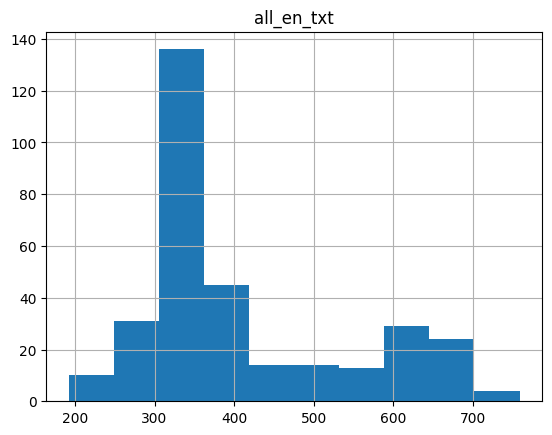

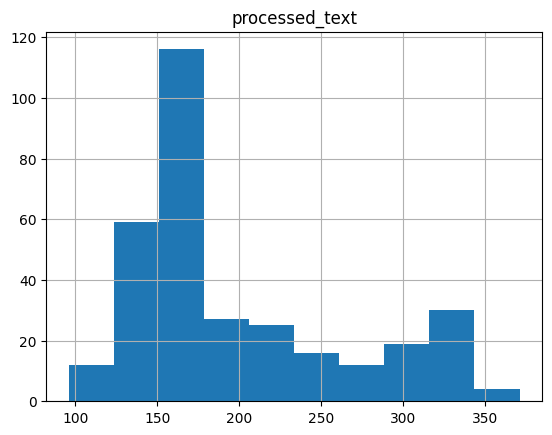

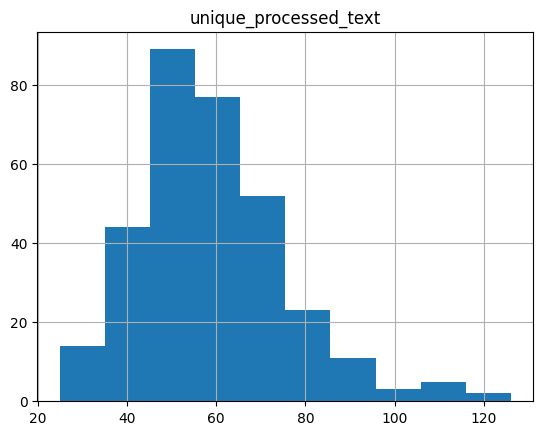

,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
count,320.00000,320.000000,320.000000
mean,410.14375,198.193750,59.484375
std,129.83099,65.650351,16.532283
min,192.00000,96.000000,25.000000
25%,324.00000,153.000000,49.000000
50%,356.00000,170.000000,57.000000
75%,488.75000,234.000000,69.000000
max,759.00000,371.000000,126.000000


In [ ]:
for i in ['all_en_txt', 'processed_text', 'unique_processed_text']:
    data_filterd[f'num_tokens_of_{i}'] = data_filterd[i].apply(lambda x: len(PUNCT_WORD_TOKENIZER.tokenize(x)))
    data_filterd[f'num_tokens_of_{i}'].hist()
    plt.title(i)
    plt.show()
data_filterd.describe()

In [ ]:
# Подсчет важности слов по корпусу из уникальных слов на основе TF-IDF векторизации
corpus_txt = data_filterd.unique_processed_text.tolist()

vectorizer = TfidfVectorizer(ngram_range=(1,2))

matrix = vectorizer.fit_transform(corpus_txt)
feature_names = vectorizer.get_feature_names_out()

all_score_df = (pd.DataFrame({'word': feature_names,
                              'score': matrix.toarray().sum(axis=0)})
                .sort_values('score')).reset_index(drop=True)
all_score_df

,word,score
0,certificate institution,0.078526
1,shop tables,0.078526
2,road papers,0.078526
3,st army,0.078526
4,wheel row,0.078526
...,...,...
9525,arafed,7.616665
9526,building,7.634163
9527,large,7.638220
9528,tower,7.655577


In [ ]:
def show_contains(df: pd.DataFrame,
                  column: str,
                  word: str):
    """
    Функция отображения контекста по входящему выражению
        df - датафрейм
        column - столбец, по которому проверяем вхождение
        word - слово/словосочетание, которое проверяем в column
    """

    df = df[df[column].str.contains(word)]
    name = df.Name.values[0]
    len_images = len(df['image'].values[0])

    display(df.head(3),
            print(f'Наименование объекта: {name}, количество картинок: {len_images}'),
        get_image(df['image'].values[0][np.random.randint(0,len_images)]))

Наименование объекта: Автомеханический техникум, количество картинок: 56


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
6,Автомеханический техникум,Ярославль,образовательное учреждение в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{arafed group of people standing in a room hol...,educational institution in Yaroslavl,educational institution in Yaroslavl arafed gr...,educational institution yaroslavl arafed group...,masks banner basketball sidewalk graffiti pict...,624,306,126


None

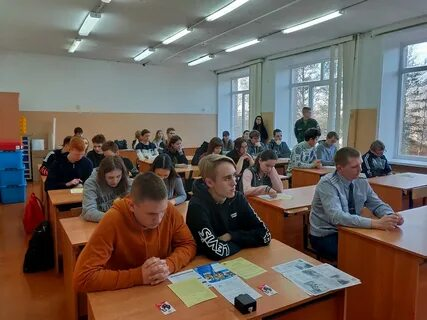

In [ ]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'][0])

Наименование объекта: Cerkiew Włodzimierskiej Ikony Matki Bożej w Jarosławiu, количество картинок: 59


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large wooden church with a steeple...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl there is a...,architectural ensemble yaroslavl large wooden ...,glass shawl ensemble picture person top icon r...,653,322,96
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large church with a steeple on the...,Church of St. Demetrius of Alexandria (Smolens...,Church of St. Demetrius of Alexandria (Smolens...,church st demetrius alexandria smolensk yarosl...,picture person top roof man front wooded build...,644,304,77
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{painting of a city with a church and a steepl...,"Armenian Church in Vladimir, Russia","Armenian Church in Vladimir, Russia painting o...",armenian church vladimir russia painting city ...,close clock water bright body church rendering...,362,164,75


None

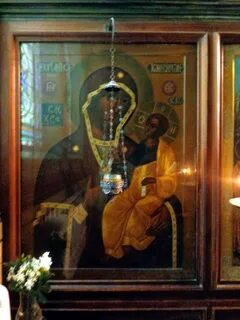

In [ ]:
show_contains(data_filterd, 'unique_processed_text', all_score_df['word'].iloc[-1])

Примененим TF-IDF к текстовым данным с отсечением редких слов

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             min_df=0.1)

matrix = vectorizer.fit_transform(corpus_txt)
feature_names = vectorizer.get_feature_names_out()

need_score_df = (pd.DataFrame({'word': feature_names,
                               'score': matrix.toarray().sum(axis=0)})
                 .sort_values('score'))
need_score_df

,word,score
10,bell,6.566453
140,snow car,6.641028
27,carriage,6.641798
126,roof painting,6.667660
55,flower,6.710812
...,...,...
35,clock,20.898767
80,large,21.110630
59,front,21.213654
19,building,21.305708


### Кластеризация данных

Выбор оптимального количество кластеров методом KMeans-кластеризации

In [ ]:
def choose_optimal_k_elbow(data, min_k: int=4, devide: int=10, step: int=100):
    """
    Функция определения оптимального количества кластеров по метрикам kmeans_score и silhouette
        data - датафрейм / матрица
        min_k - минимальное количество кластеров
        devide - делитель размера данных, чтобы ограничить максимальное количество кластеров
        step - шаг изменения количества кластеров
    """
    k_scores = []
    s_scores = []

    k_max = int(data.shape[0]/devide)

    k_values = range(min_k, k_max, step)

    for k in tqdm(k_values):
        kmeans = KMeans(n_clusters=k,
                        init='k-means++',
                        n_init=10,
                        max_iter=300,
                        tol=0.0001,
                        random_state=42)

        preds = kmeans.fit_predict(data)

        k_scores.append(-kmeans.score(data))

        # Silhouette Score
        silhouette = silhouette_score(data, preds)
        s_scores.append(silhouette)

    plt.plot(k_values, k_scores, marker='o')
    plt.title('Метод локтя')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Значение метрики')
    plt.show()

    plt.plot(k_values, s_scores, marker='o')
    plt.title('Метрика Silhouette KMeans модели при разном значении размера кластера')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Значение метрики')
    plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

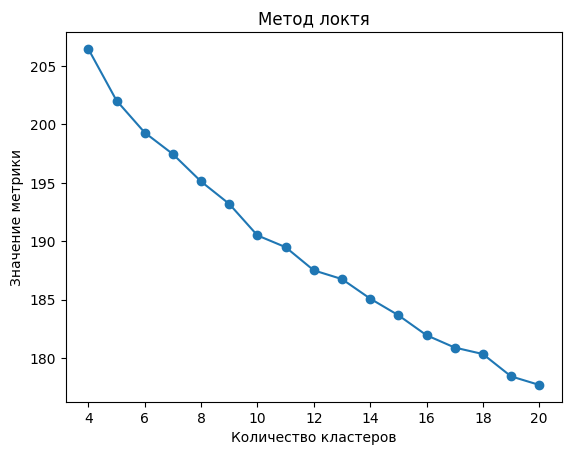

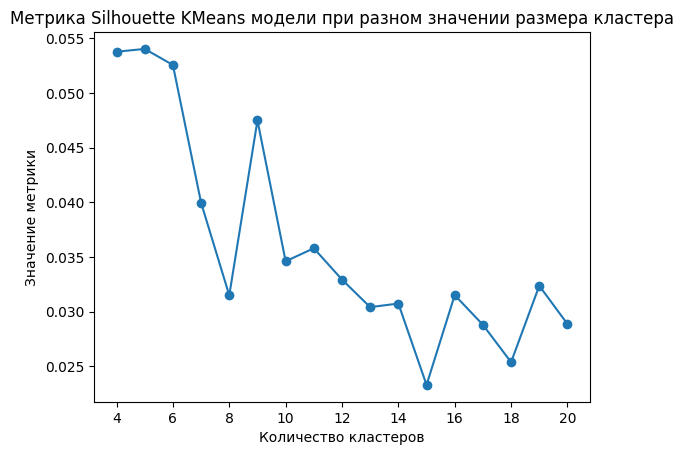

In [ ]:
choose_optimal_k_elbow(matrix, devide=15, step=1)

Посмотрим сколько объектов в каждом кластере

In [ ]:
km_clustering = KMeans(
    n_clusters=6,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001)

data_filterd['prediction'] = km_clustering.fit_predict(matrix)
prediction_counts = (data_filterd['prediction']
                     .value_counts()
                     .sort_values()
                     .reset_index()
                     .rename(columns={'count':'v_counts'})
                    )
prediction_counts.head()

,prediction,v_counts
0,0,29
1,4,34
2,3,41
3,5,51
4,1,71


In [ ]:
' | '.join(f'{k}: {v:.2f}' for k, v in prediction_counts['v_counts'].describe().items())

'count: 6.00 | mean: 53.33 | std: 24.86 | min: 29.00 | 25%: 35.75 | 50%: 46.00 | 75%: 66.00 | max: 94.00'

Выбор кластеров с количеством наблюдений, входящих в топ-90%

In [ ]:
need_clusters = (prediction_counts[prediction_counts['v_counts']
                 >=prediction_counts['v_counts'].quantile(0.1)]
                 .prediction)

# Посмотрим как меняется количество наблюдений после фильтрации
print(data_filterd.shape,
      data_filterd[data_filterd['prediction'].isin(need_clusters)].shape)

(320, 13) (291, 13)


Посмотрим, как изменилось распределение объектов по городам после фильтрации данных по кластеризации.

In [ ]:
(
  data_filterd.City.value_counts(),
  data_filterd[data_filterd['prediction'].isin(need_clusters)].City.value_counts()
)

(City
 Нижний Новгород    98
 Екатеринбург       97
 Ярославль          96
 Владимир           29
 Name: count, dtype: int64,
 City
 Нижний Новгород    93
 Екатеринбург       87
 Ярославль          84
 Владимир           27
 Name: count, dtype: int64)

In [ ]:
data_filterd = data_filterd[data_filterd['prediction'].isin(need_clusters)]
print(data_filterd.shape)
data_filterd.head()

(291, 13)


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction
0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Ярославль,Православный храм в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a small white and orange building wi...,Orthodox Church in Yaroslavl,Orthodox Church in Yaroslavl there is a small ...,orthodox church yaroslavl small white orange b...,yaroslavl towers church steeples fence large d...,265,130,30,2
1,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Ярославль,Архитектурный ансамбль в Ярославле,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large wooden church with a steeple...,Architectural ensemble in Yaroslavl,Architectural ensemble in Yaroslavl there is a...,architectural ensemble yaroslavl large wooden ...,glass shawl ensemble picture person top icon r...,653,322,96,2
2,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Ярославль,Церковь великомученика Димитрия Солунского (См...,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large church with a steeple on the...,Church of St. Demetrius of Alexandria (Smolens...,Church of St. Demetrius of Alexandria (Smolens...,church st demetrius alexandria smolensk yarosl...,picture person top roof man front wooded build...,644,304,77,2
3,église arménienne de Vladimir,Владимир,Армянская церковь в г. Владимир России,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{painting of a city with a church and a steepl...,"Armenian Church in Vladimir, Russia","Armenian Church in Vladimir, Russia painting o...",armenian church vladimir russia painting city ...,close clock water bright body church rendering...,362,164,75,2
4,Авиамеханический колледж,Владимир,Владимирский авиамеханический колледж,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large building with a clock tower ...,Vladimir Aviation Mechanical College,Vladimir Aviation Mechanical College there is ...,vladimir aviation mechanical college large bui...,close clock students pens buses state robots w...,343,167,64,1


In [ ]:
# Рассчитаем и сохраним длину текстов в соответствующих столбцах
for i in ['Name', 'City', 'description']:
    data_filterd[f'len_{i}'] = data_filterd[i].apply(lambda x: len(str(x)))
display(data_filterd.describe())

,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000
mean,405.900344,197.463918,59.505155,2.656357,26.584192,11.721649,33.439863
std,129.014756,65.859316,16.714308,1.416206,12.861958,2.627739,22.375918
min,192.000000,96.000000,25.000000,1.000000,4.000000,8.000000,5.000000
25%,323.000000,153.000000,49.000000,2.000000,18.000000,9.000000,22.000000
50%,355.000000,168.000000,57.000000,2.000000,25.000000,12.000000,29.000000
75%,471.500000,232.000000,69.000000,4.000000,32.000000,15.000000,37.000000
max,759.000000,358.000000,126.000000,5.000000,76.000000,15.000000,225.000000


### Обработка неявных дубликатов

In [ ]:
# количество и список уникальных значений в столбце Name
(
  data_filterd.Name.nunique(),
  data_filterd.Name.unique().tolist()
)

(288,
 ['Cerkiew Narodzenia Pańskiego w Jarosławiu',
  'Cerkiew Włodzimierskiej Ikony Matki Bożej w Jarosławiu',
  'Cerkiew św. Dymitra Sołuńskiego w Jarosławiu',
  'église arménienne de Vladimir',
  'Авиамеханический колледж',
  'Автозаводский парк культуры и отдыха',
  'Автомеханический техникум',
  'Администрация Нижнего Новгорода',
  'Александро-Невская часовня',
  'Александро-Невский собор',
  'Белая башня',
  'Белокаменные памятники Владимира и Суздаля',
  'Беседка на Волжской набережной',
  'Благовещенский монастырь',
  'Благовещенский собор',
  'Блиновский пассаж',
  'Богородице-Рождественский мужской монастырь',
  'Богоявленская башня',
  'Больница имени Н. В. Соловьёва',
  'Борисоглебская башня',
  'Бутусовский посёлок',
  'Бывшая водонапорная башня',
  'Вечный огонь (Ярославль)',
  'Владимиро-Суздальский музей-заповедник (центральный офис)',
  'Владимирская духовная семинария',
  'Владимирская церковь',
  'Владимирский академический областной драматический театр',
  'Владими

In [ ]:
drop_names = ['Автомеханический техникум', 'Администрация Нижнего Новгорода',
              'Больница имени Н. В. Соловьёва', 'Нижегородское речное училище', 'Рекорд'
              'Школа № 33 имени Карла Маркса',
             ]

In [ ]:
data_filterd = data_filterd[~data_filterd.Name.isin(drop_names)].reset_index(drop=True)
data_filterd.to_csv('data_filterd.csv', index=False)
print(data_filterd.shape)

(287, 16)


---

## Реализация RAG системы

### Формирование базы знаний

Сформируем базу знаний для будущего поиска по ней и передачи контекста в LLM

In [ ]:
# Передаем контент и метаинформацию в LangchainDocument

RAW_KNOWNLEDGE_BASE = [
    LangchainDocument(
        page_content=data_filterd["Name"][i] + ': ' + data_filterd["description"][i],
        metadata={"City": data_filterd["City"][i]
#                  , "image": data_filterd["image"][i]
                 })
    for i in tqdm(range(len(data_filterd)))
]

  0%|          | 0/287 [00:00<?, ?it/s]

In [ ]:
# Разбиение длинных документов на чанки

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

CHUNK_SIZE = 512

TEXT_SPLITTER = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,  # Максимальное количество символов в чанке
    chunk_overlap=int(CHUNK_SIZE * 0.1),  # Количество символов, которые будут перекрываться между чанками
    add_start_index=True,  # Если "True", то включает начальный индекс чанка в метаданные
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)

#  список чанков
docs_processed = []
for doc in RAW_KNOWNLEDGE_BASE:
    docs_processed += TEXT_SPLITTER.split_documents([doc])

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model's maximum sequence length: 32768


  0%|          | 0/287 [00:00<?, ?it/s]

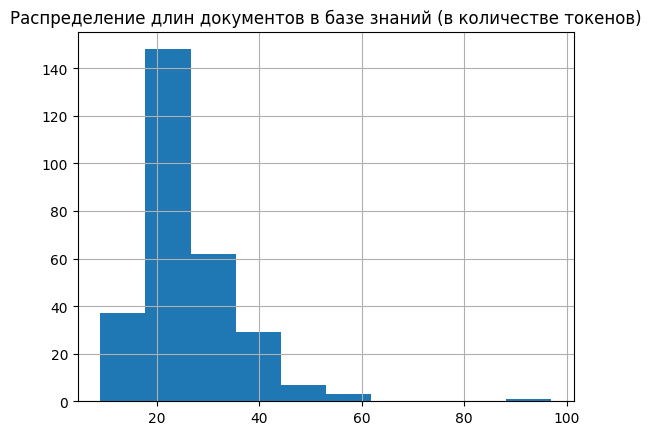

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME,
#                                          max_length=1024
                                         )
# Получение максимальной длины и подсчёт длины каждого чанка
print(f"Model's maximum sequence length: {SentenceTransformer(MODEL_NAME).max_seq_length}")
lengths = [len(TOKENIZER.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Визуализация
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

### Модель Retriever+Reranker в системе RAG

Создание эмбеддинг-модели и векторной базы для использования в пайплайне RAG для поиска релевантных текстов по смыслу

In [ ]:
def create_embedding_model(model_name):
    """
    Функция создания ембеддинг модели
    """
    try:
        embedding_model = HuggingFaceEmbeddings(
            model_name=model_name,
            multi_process=True,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"normalize_embeddings": True}, # `True` для косинусного сходства
        )

        print(f"Embedding model created")
        return embedding_model

    except Exception as e:
        print(f"Error creating embedding model: {str(e)}")
        return None

In [ ]:
MODEL_NAME = "cointegrated/LaBSE-en-ru"

In [ ]:
%%time

EMBEDDING_MODEL = create_embedding_model(MODEL_NAME)
if EMBEDDING_MODEL:
    try:
        KNOWNLEDGE_VECTOR_DATABASE = Chroma.from_documents(docs_processed, EMBEDDING_MODEL)
        print(f"Vector database created")
    except Exception as e:
        print(f"Error creating vector database: {str(e)}")

Embedding model created


2025-06-08 07:03:27.353050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366207.375038    4064 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366207.381768    4064 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:03:35.274257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366215.295833    4076 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366215.302530    4076 cuda_blas.cc:1

Chunks:   0%|          | 0/20 [00:00<?, ?it/s]

Vector database created
CPU times: user 1.08 s, sys: 837 ms, total: 1.92 s
Wall time: 19.5 s


In [ ]:
# Проверка пользовательским запросом на основе косинусного сходства
user_query = "Что можно посмотреть в Екатеринбурге?"
query_vector = EMBEDDING_MODEL.embed_query(user_query)
print(f"\nStarting retrieval for {user_query=}...")

retrieved_docs = KNOWNLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=10)
print("\n==================================Топ похожих документов==================================")
for i in tqdm(range(len(retrieved_docs))):
    print(i, ' - '.join([retrieved_docs[i].metadata['City'],
                         retrieved_docs[i].page_content]))
    print('='*70)

2025-06-08 07:03:44.662757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366224.684903    4107 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366224.691638    4107 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:03:52.640628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366232.662457    4119 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366232.669178    4119 cuda_blas.cc:1

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


Starting retrieval for user_query='Что можно посмотреть в Екатеринбурге?'...


2025-06-08 07:04:01.168930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366241.190900    4139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366241.197675    4139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:04:09.116169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366249.139266    4151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366249.146424    4151 cuda_blas.cc:1

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


==================================Топ похожих документов==================================


  0%|          | 0/10 [00:00<?, ?it/s]

0 Екатеринбург - Музей истории Екатеринбурга: музей в Екатеринбурге
1 Екатеринбург - Екатеринбургский музей изобразительных искусств: музей в Екатеринбурге
2 Екатеринбург - Музей изобразительных искусств: музей в Екатеринбурге
3 Екатеринбург - Уральский геологический музей: музей в Екатеринбурге
4 Екатеринбург - Центральный стадион: стадион в Екатеринбурге
5 Екатеринбург - Музей «Литературная жизнь Урала XIX века»: Литературный музей в Екатеринбурге
6 Екатеринбург - №19 Музей истории Екатеринбурга: музей в Екатеринбурге
7 Екатеринбург - Дом Артистов: здание в Екатеринбурге
8 Екатеринбург - Художественный Музей Эрнста Неизвестного: музей в Екатеринбурге
9 Екатеринбург - Малышеву: Памятник в Екатеринбурге


In [ ]:
# Переранжирование документов с помощью модели colbertv2.0
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

print(f"\nStarting retrieval for {user_query=}...")
relevant_docs = [doc.page_content for doc in retrieved_docs]
relevant_docs = RERANKER.rerank(user_query, relevant_docs, k=5)

print("==================================Топ 1 проранжированный документ==================================")
print(relevant_docs[0])


Starting retrieval for user_query='Что можно посмотреть в Екатеринбурге?'...


100%|██████████| 1/1 [00:00<00:00, 53.52it/s]

==================================Топ 1 проранжированный документ==================================
{'content': 'Художественный Музей Эрнста Неизвестного: музей в Екатеринбурге', 'score': 25.96875, 'rank': 0, 'result_index': 8}


Наименование объекта: Художественный Музей Эрнста Неизвестного, количество картинок: 27


,Name,City,description,image,en_txt,en_description,all_en_txt,processed_text,unique_processed_text,num_tokens_of_all_en_txt,num_tokens_of_processed_text,num_tokens_of_unique_processed_text,prediction,len_Name,len_City,len_description
227,Художественный Музей Эрнста Неизвестного,Екатеринбург,музей в Екатеринбурге,[/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFB...,{there is a large white building with a clock ...,Museum in Yekaterinburg,Museum in Yekaterinburg there is a large white...,museum yekaterinburg large white building cloc...,glass clock close display sculpture set fence ...,310,131,60,5,40,12,21


None

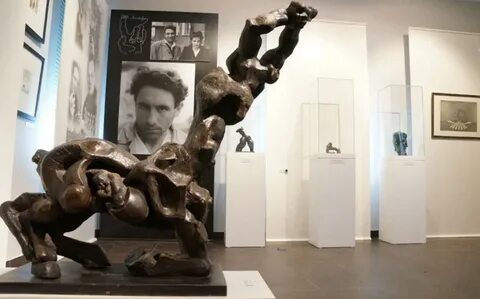

In [ ]:
show_contains(data_filterd, 'Name', relevant_docs[0]['content'].split(':')[0])

### Модель-генератор в системе RAG

Создадим конфиг для загрузки модели в 4-битах и пайплайн для генерации ответов

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

MODELLLM = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                                quantization_config=bnb_config)

READER_LLM = pipeline(
    model=MODELLLM,
    tokenizer=TOKENIZER,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500)

Device set to use cuda:0


### Шаблон запроса

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.""",
    },
    {
        "role": "user",
        "content": """Контекст: {context} \n---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}""",
    },
]


RAG_PROMPT_TEMPLATE = TOKENIZER.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: {context} 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}<|im_end|>
<|im_start|>assistant



Формирование финального промпта для генерации ответа

In [ ]:
relevant_docs_text = [doc['content'] for doc in relevant_docs]
context = "\nИзвлеченные документы:\n"
context += "".join([f"Документ {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question=user_query, context=context)

answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

В Екатеринбурге есть несколько интересных музеев и памятников. Например, Художественный Музей Эрнста Неизвестного, Центральный стадион, Памятник Малышеву, а также Музей истории Екатеринбурга.


### Реализация пайплайна RAG

извлечение -> ранжирование -> генерация

In [ ]:
def answer_with_rag(
    question: str,
    rag_prompt: str,
    llm: pipeline,
    knowledge_index,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
    printing: bool=True
) -> Tuple[str, List[LangchainDocument]]:

    # Извлечение документов по семантическому сходству
    if printing:
        print("=> Получение документов...")
    retrieved_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in retrieved_docs]

    # Ранжирование
    if reranker:
        if printing:
            print("=> Ранжирование документов...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Формируем контекста и финальный промпт
    context = "\nИзвлеченные документы:"
    context += " ".join([f"\nДокумент {str(i)}: " + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = rag_prompt.format(question=question, context=context)
    if printing:
        print(f'Промт для RAG: \n\n{final_prompt}')
        print("=> Генерация ответа...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

Запуск RAG-пайплайна для каждого города

In [ ]:
%%time

QUESTION = "Что посетить в Екатеринбурге?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...


2025-06-08 07:04:28.090495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366268.112187    4171 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366268.118947    4171 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:04:35.973181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366275.994801    4183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366276.001732    4183 cuda_blas.cc:1

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

=> Ранжирование документов...


100%|██████████| 1/1 [00:00<00:00, 20.55it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Дом печати (Екатеринбург): здание в Екатеринбурге 
Документ 1: Александро-Невская часовня: часовня в Екатеринбурге 
Документ 2: Площадь 1-й Пятилетки: городская площадь в Екатеринбурге 
Документ 3: Центральный стадион: стадион в Екатеринбурге 
Документ 4: Дом Промышленности: здание в Екатеринбурге 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: Что посетить в Екатеринбурге?<|im_end|>
<|im_start|>assistant

=> Генерация ответа...


==================================Ответ==================================

В Екатеринбурге есть много интересных достопримечательностей. Вы можете посетить дом печати, Александро-Невскую часовню, площадь 1-й Пятилетки, центральный стадион или дом промышленности.
CPU times: user 5.22 s, sys: 126 ms, total: 5.34 s
Wall time: 21.6 s


In [ ]:
%%time

QUESTION = "Что посмотреть в городе Ярославль?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...


2025-06-08 07:04:49.732567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366289.754171    4203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366289.760848    4203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:04:57.706124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366297.727543    4215 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366297.734274    4215 cuda_blas.cc:1

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

=> Ранжирование документов...


100%|██████████| 1/1 [00:00<00:00, 22.89it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Церковь Богоявления Господня: Православный храм в Ярославле 
Документ 1: Церковь Спаса на городу: Православный храм в Ярославле 
Документ 2: Николая Чудотворца: храм в Ярославле 
Документ 3: Гостиный двор (Ярославль): Торговые ряды в Ярославле 
Документ 4: Мост Волжские Ворота: мост в Ярославле 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: Что посмотреть в городе Ярославль?<|im_end|>
<|im_start|>assistant

=> Генерация ответа...


==================================Ответ==================================

В городе Ярославль есть несколько достопримечательностей, которые стоит посетить. Это церкви Богоявления Господня, Спаса на Городе и Николая Чудотворца, а также гостиный двор и мост Волжские Ворота.
CPU times: user 5.76 s, sys: 127 ms, total: 5.89 s
Wall time: 22.3 s


In [ ]:
%%time

QUESTION = "Какие места стоит посетить в Нижнем Новгороде?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...


2025-06-08 07:05:12.028202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366312.051306    4235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366312.058074    4235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:05:19.995155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366320.017091    4247 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366320.023827    4247 cuda_blas.cc:1

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

=> Ранжирование документов...


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Дом Сироткина: памятник архитектуры Нижнего Новгорода, корпус Художественного музея 
Документ 1: Нижегородский кремль: Крепость в центре Нижнего Новгорода 
Документ 2: Усадьба Добролюбовых: единственный в мире музей литературного критика и писателя Николая Александровича Добролюбова, расположенный в Нижнем Новгороде. 
Документ 3: Парк имени А.С. Пушкина: парк культуры и отдыха в Нижнем Новгороде. 
Документ 4: Дом-музей Добролюбова: единственный в мире музей литературного критика и писателя Николая Александровича Добролюбова, расположенный в Нижнем Новгороде. 
---
А теперь вопрос, на который вам нужно ответить

==================================Ответ==================================

В Нижнем Новгороде есть несколько интересных достопримечательностей, которые стоит посетить:

1. Дом Сироткина - памятник архитектуры.
2. Нижегородский кремль - древняя крепостная структура.
3. Усадьба Добролюбовых - уникальный музей литературы.
4. Парк имени А.С. Пушкина - культурно-оздоровительное здание.

Эти места представляют собой исторические памятники, культурные объекты и культурно-просветительские учреждения, что делает их особенно привлекательными для туристов и исследователей города.
CPU times: user 13.6 s, sys: 138 ms, total: 13.7 s
Wall time: 30.3 s


In [ ]:
%%time

QUESTION = " Я в городе Владимир, подскажи куда сходить?"

answer, relevant_docs = answer_with_rag(QUESTION, RAG_PROMPT_TEMPLATE, READER_LLM, KNOWNLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Ответ==================================\n")
print(f"{answer}")

=> Получение документов...


2025-06-08 07:05:42.302552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366342.324064    4267 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366342.330741    4267 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:05:50.188198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366350.209619    4279 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366350.216234    4279 cuda_blas.cc:1

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

=> Ранжирование документов...


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]

Промт для RAG: 

<|im_start|>system
Ты чат бот ГИД, который помогает ориентироваться в городе,
а также рассказывает о местах и достопримечательностях в нем.
Используя информацию, содержащуюся в контексте, напиши краткий ответ на заданный вопрос.
Если ответ невозможно вывести из контекста скажи, что не знаешь.<|im_end|>
<|im_start|>user
Контекст: 
Извлеченные документы:
Документ 0: Дом-музей Столетовых: Мемориальный музей в городе Владимире, посвящённый жизни и деятельности выдающегося учёного-физика А. Г. Столетова и генерала от инфантерии Н. Г. Столетова, сыгравшего видную роль в освобождении Болгарии от турецкого ига 
Документ 1: Белокаменные памятники Владимира и Суздаля: Белокаменные памятники Владимира и Суздаля 
Документ 2: Собор Успения Пресвятой Богородицы: православный храм во Владимире, памятник белокаменного зодчества домонгольской Руси 
Документ 3: Усадьба Добролюбовых: единственный в мире музей литературного критика и писателя Николая Александровича Добролюбова, расположен

==================================Ответ==================================

Ваш город - Владимир! Здесь много интересных достопримечательностей. Например, есть дом-музей Столетовых, где можно узнать об известных людях города. Также стоит посетить Белокаменные памятники, которые являются символами древнего города. Если хотите посмотреть православные храмы, то рекомендую посетить Собор Успения Пресвятой Богородицы или Князь-Владимирскую церковь. Так что, если вы приедете в Владимир, обязательно посмотрите эти места!
CPU times: user 10.4 s, sys: 184 ms, total: 10.6 s
Wall time: 26.9 s


---

### Визуализация эмбеддингов PCA и UMAP

In [ ]:
# PCA
pca_emb = PCA(n_components=2, random_state=42)
documents_projected = pca_emb.fit_transform(KNOWNLEDGE_VECTOR_DATABASE.get(include=["embeddings"])['embeddings'])

df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["City"],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Визуализируем эмбеддинги
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью PCA</b>",
)
fig.show()

**Вывод:**
1. Запрос пользователя о Екатеринбурге оказался близким к релевантным документам

2. Документы из одного города в большинстве случаев группируются — эмбеддинги адекватно отражают смысл

3. Визуализация подтверждает, что векторная база работает корректно, а ответ модели формируется на основе близких по смыслу источников.

In [ ]:
# UMAP
umap_emb = umap.UMAP(n_components=2, random_state=42)

documents_projected = umap_emb.fit_transform(KNOWNLEDGE_VECTOR_DATABASE.get(include=["embeddings"])['embeddings'])

df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["City"],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Визуализируем эмбеддинги
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью UMAP</b>",
)
fig.show()

**Вывод:**
1. UMAP даёт более чёткую и интерпретируемую картину, чем PCA

2. Запрос пользователя хорошо соотносится с релевантными документами из Екатеринбурга

3. Модель адекватно группирует тексты

## Оценка эффективности модели RAG на основе RAGAS

Будем использовать метрику `Answer Relevancy`



Для этого создадим датасет со следующими полями:

1. `question` - колонка содержит вопросы, на которые нужно найти ответы
2. `ground_truths` - колонка с правильными ответами на соответствующие вопросы. Позволит сравнить сгенерированные ответы с эталонными
3. `answer` - колонка содержит ответы, которые генерирует модель на основе заданных вопросов
4. `contexts` - колонка c контекстом или дополнительной информацией, которая может быть полезна для понимания вопроса или для формирования ответа.

In [ ]:
# Загрузим модель для извлечения ембеддингов по тексту
emb_model = SentenceTransformer(MODEL_NAME)

def data_preprocess(df, n_samples):
    """
    Функция генерации датасета  для проверки нашей RAG системы
        df - датафрейм
        n_samples - количество случайно взятых наблюдений
    """
    sample = df.sample(n_samples, random_state=SEED)

    question = list()
    ground_truths = list()

    for i, row in sample.iterrows():
        question.append(f"Что можно посмотреть в городе {row['City']}?")
        ground_truths.append(row['Name'])

    gen_sample = pd.DataFrame({'question': question,
                               'ground_truths': ground_truths})

    return gen_sample

def answer_relevancy(df, embedding_model):
    """
    Функция для расчета метрики answer relevancy
        df - датафрейм
        embedding_model - модель для извлечения эмбеддингов
    """
    scores = list()

    # Средняя косинусная близость между вопросом и ответом
    for i, row in tqdm(df.iterrows()):
        question_emb = embedding_model.encode(row['question'])
        answer_emb = embedding_model.encode(row['answer'])
        scores.append(cosine_similarity([answer_emb], [question_emb])[0][0])

    return (sum(scores)/len(df))

In [ ]:
# Генерация 50 вопросов с ответами
data_gen = data_preprocess(data_filterd, 50)
print(data_gen.shape)
data_gen.head()

(50, 2)


,question,ground_truths
0,Что можно посмотреть в городе Нижний Новгород?,Белая башня
1,Что можно посмотреть в городе Екатеринбург?,Шарташские каменные палатки
2,Что можно посмотреть в городе Нижний Новгород?,Нижегородский кремль
3,Что можно посмотреть в городе Екатеринбург?,Успенский собор на ВИЗе
4,Что можно посмотреть в городе Екатеринбург?,Центральный стадион


In [ ]:
# промпт для RAG c установкой роли ассистента — «путешественник»
new_prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Ты путешественник. Резюмируя информацию, которая содержится в контексте, ответь на вопрос.""",
    },
    {
        "role": "user",
        "content": """Контекст: {context} \n---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}""",
    },
]


NEW_RAG_PROMPT_TEMPLATE = TOKENIZER.apply_chat_template(
    new_prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(NEW_RAG_PROMPT_TEMPLATE)

<|im_start|>system
Ты путешественник. Резюмируя информацию, которая содержится в контексте, ответь на вопрос.<|im_end|>
<|im_start|>user
Контекст: {context} 
---
А теперь вопрос, на который вам нужно ответить.
Вопрос: {question}<|im_end|>
<|im_start|>assistant



In [ ]:
%%time

# Ответы модели RAG
answers = list()
contexts = list()
for i, row in tqdm(data_gen.iterrows()):
    answer, context = answer_with_rag(row['question'],
                                NEW_RAG_PROMPT_TEMPLATE,
                                READER_LLM,
                                KNOWNLEDGE_VECTOR_DATABASE,
                                reranker=RERANKER,
                                printing=False)
    answers.append(answer)
    contexts.append('; '.join([i for i in context]))

data_gen['contexts'] = contexts
data_gen['answer'] = answers
print(data_gen.shape)
data_gen.head()

0it [00:00, ?it/s]

2025-06-08 07:06:21.999017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366382.021624    4302 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366382.028476    4302 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:06:29.982912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366390.004876    4314 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366390.011516    4314 cuda_blas.cc:1

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]
2025-06-08 07:06:54.669422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366414.691794    4334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366414.698526    4334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:07:02.666890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366422.688586    4346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.48it/s]
2025-06-08 07:07:23.797628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366443.820525    4366 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366443.827471    4366 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:07:31.801569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366451.823925    4378 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.68it/s]
2025-06-08 07:07:56.667785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366476.690174    4398 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366476.696882    4398 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:08:04.702683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366484.724242    4410 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.44it/s]
2025-06-08 07:08:24.442599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366504.465369    4430 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366504.472256    4430 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:08:32.477446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366512.499174    4442 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.45it/s]
2025-06-08 07:08:52.018041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366532.040266    4462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366532.046995    4462 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:08:59.946719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366539.968773    4474 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
2025-06-08 07:09:20.052306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366560.074960    4494 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366560.081796    4494 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:09:27.991111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366568.012799    4506 cuda_dnn.cc:8310] Unable to regis

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]
2025-06-08 07:09:52.459396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366592.481818    4526 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366592.488497    4526 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:10:00.344884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366600.366789    4538 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.40it/s]
2025-06-08 07:10:26.405537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366626.427348    4558 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366626.434029    4558 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:10:34.408895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366634.430784    4570 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]
2025-06-08 07:11:03.689147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366663.711614    4590 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366663.718383    4590 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:11:11.748293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366671.769895    4602 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.79it/s]
2025-06-08 07:11:39.225635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366699.248292    4622 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366699.255478    4622 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:11:47.253043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366707.274786    4634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.73it/s]
2025-06-08 07:12:12.029425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366732.051212    4654 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366732.057937    4654 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:12:19.943586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366739.965770    4666 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.86it/s]
2025-06-08 07:12:43.275247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366763.300069    4686 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366763.306904    4686 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:12:51.241431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366771.263346    4698 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.79it/s]
2025-06-08 07:13:15.715568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366795.738049    4718 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366795.744783    4718 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:13:23.657568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366803.679082    4730 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.66it/s]
2025-06-08 07:13:38.724179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366818.746531    4750 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366818.753439    4750 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:13:46.724401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366826.745804    4762 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]
2025-06-08 07:14:11.309038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366851.331730    4782 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366851.338528    4782 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:14:19.334803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366859.357515    4794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]
2025-06-08 07:14:44.160675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366884.183217    4814 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366884.190069    4814 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:14:52.218462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366892.240260    4826 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.84it/s]
2025-06-08 07:15:15.855497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366915.877314    4846 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366915.883995    4846 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:15:23.926992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366923.950776    4858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.82it/s]
2025-06-08 07:15:53.736782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366953.759005    4878 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366953.765689    4878 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:16:01.690444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366961.712175    4890 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]
2025-06-08 07:16:26.795270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366986.817312    4910 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366986.824501    4910 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:16:34.745620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366994.767179    4922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.59it/s]
2025-06-08 07:16:54.753641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367014.776089    4942 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367014.782987    4942 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:17:02.717852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367022.739708    4954 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.91it/s]
2025-06-08 07:17:19.015759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367039.038466    4974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367039.045222    4974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:17:27.034947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367047.056862    4986 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]
2025-06-08 07:17:46.545995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367066.567905    5006 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367066.574631    5006 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:17:54.491676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367074.513073    5018 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.86it/s]
2025-06-08 07:18:18.878398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367098.901081    5038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367098.907902    5038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:18:26.837696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367106.859984    5050 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]
2025-06-08 07:18:41.929865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367121.952659    5070 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367121.960158    5070 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:18:49.895060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367129.916809    5084 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]
2025-06-08 07:19:13.457137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367153.481033    5104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367153.487849    5104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:19:21.377381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367161.398969    5116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]
2025-06-08 07:19:47.416180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367187.437810    5136 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367187.444502    5136 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:19:55.367465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367195.389146    5148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.64it/s]
2025-06-08 07:20:11.083944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367211.105983    5168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367211.112725    5168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:20:19.240354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367219.262081    5180 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.46it/s]
2025-06-08 07:20:35.450621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367235.473220    5200 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367235.480045    5200 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:20:43.572449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367243.593980    5212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.38it/s]
2025-06-08 07:21:05.878902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367265.900718    5232 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367265.907452    5232 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:21:13.891623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367273.913710    5244 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.83it/s]
2025-06-08 07:21:39.059141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367299.082025    5264 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367299.088891    5264 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:21:47.040406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367307.062636    5276 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.74it/s]
2025-06-08 07:22:11.362876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367331.385268    5296 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367331.392217    5296 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:22:19.309144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367339.330815    5308 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.70it/s]
2025-06-08 07:22:34.504465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367354.526922    5328 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367354.533591    5328 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:22:42.588034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367362.610082    5340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]
2025-06-08 07:23:07.388045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367387.411300    5360 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367387.418351    5360 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:23:15.435362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367395.456878    5372 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]
2025-06-08 07:23:32.601643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367412.624447    5392 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367412.631170    5392 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:23:40.589251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367420.611876    5404 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]
2025-06-08 07:24:06.260262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367446.283123    5424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367446.290057    5424 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:24:14.394460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367454.417458    5436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.73it/s]
2025-06-08 07:24:36.655812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367476.678860    5456 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367476.686516    5456 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:24:44.705818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367484.727284    5468 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.46it/s]
2025-06-08 07:25:01.161740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367501.184061    5488 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367501.190810    5488 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:25:09.141151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367509.162866    5500 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]
2025-06-08 07:25:33.220020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367533.243202    5520 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367533.249973    5520 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:25:41.187220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367541.209085    5532 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.62it/s]
2025-06-08 07:26:07.860639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367567.882837    5552 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367567.889624    5552 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:26:15.846847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367575.868590    5564 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
2025-06-08 07:26:31.524358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367591.547558    5584 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367591.554386    5584 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:26:39.597789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367599.619450    5596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.65it/s]
2025-06-08 07:26:54.879515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367614.902543    5616 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367614.909430    5616 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:27:02.848373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367622.870380    5628 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.46it/s]
2025-06-08 07:27:24.897166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367644.919893    5648 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367644.926609    5648 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:27:32.851158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367652.873549    5660 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]
2025-06-08 07:27:56.454933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367676.476680    5680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367676.483574    5680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:28:04.446839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367684.468233    5692 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
2025-06-08 07:28:33.561704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367713.583280    5712 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367713.589926    5712 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:28:41.500732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367721.522421    5724 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]
2025-06-08 07:29:00.892553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367740.915343    5744 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367740.922304    5744 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:29:08.881269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367748.903586    5756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]
2025-06-08 07:29:37.371461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367777.393571    5776 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367777.400203    5776 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:29:45.342689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367785.364655    5788 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]
2025-06-08 07:30:06.865815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367806.888475    5808 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367806.895481    5808 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:30:14.881473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367814.902774    5820 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 22.85it/s]
2025-06-08 07:30:30.782657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367830.804832    5840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367830.811527    5840 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:30:38.843939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367838.865275    5852 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 20.54it/s]
2025-06-08 07:30:58.600073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367858.622024    5872 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749367858.628786    5872 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:31:06.660385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749367866.682073    5884 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


(50, 4)
CPU times: user 11min 13s, sys: 5.49 s, total: 11min 18s
Wall time: 25min 8s


,question,ground_truths,contexts,answer
0,Что можно посмотреть в городе Нижний Новгород?,Белая башня,Печёрский Вознесенский монастырь: монастырь в ...,В городе Нижний Новгород можно посетить следую...
1,Что можно посмотреть в городе Екатеринбург?,Шарташские каменные палатки,Площадь 1-й Пятилетки: городская площадь в Ека...,В городе Екатеринбург можно посетить следующие...
2,Что можно посмотреть в городе Нижний Новгород?,Нижегородский кремль,Печёрский Вознесенский монастырь: монастырь в ...,В городе Нижний Новгород можно посетить следую...
3,Что можно посмотреть в городе Екатеринбург?,Успенский собор на ВИЗе,Площадь 1-й Пятилетки: городская площадь в Ека...,В городе Екатеринбург можно посетить следующие...
4,Что можно посмотреть в городе Екатеринбург?,Центральный стадион,Площадь 1-й Пятилетки: городская площадь в Ека...,В городе Екатеринбург можно посетить следующие...


In [ ]:
%%time

# Оценка метрики Answer Relevancy
AR = answer_relevancy(data_gen, emb_model)
print(f"Answer Relevancy:{AR:.3f}")

0it [00:00, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Answer Relevancy:0.939
CPU times: user 13.4 s, sys: 267 ms, total: 13.6 s
Wall time: 13.4 s


In [ ]:
print(f"Answer Relevancy:{AR:.3f}")

Answer Relevancy:0.939


## **Выводы по работе:**


# **Выводы по работе:**    

**Анализ и подготовка исходных данных:**
- Для формирования корпуса по достопримечательностям были использованы информативные поля  `Name, City, Description`. Текстовые описания и англоязычные метаданные изображений были агрегированы с помощью функции set, обеспечив максимальное покрытие информации об объектах без дублирования.

**Очистка данных и выявление выбросов:**

- Выполнен машинный перевод описаний на английский язык.

- Объединены текстовые поля: описание достопримечательности и описание изображений.

- Реализована текстовая предобработка и `TF-IDF`-векторизация.

- Проведена кластеризация после подбора оптимального количества кластеров.

- В результате ручной модерации удалены неявные дубликаты

**Реализация `RAG`-системы:**

- Сформирована векторная база на основе `Chroma`.

- Для улучшения отбора релевантных документов применяется `ColBERT v2.0` в качестве реранкера.

- Генерация ответов осуществляется с помощью модели `Qwen2.5-1.5B`.

**Работа с шаблонами промптов:**

- Использован кастомный промпт в формате LLM, адаптированный под туризм - ориентированные запросы.

- Проведено тестирование на различных городах. Менее хорошо модель сработала для города Владимир из-за ограниченного числа документов по нему (более, чем в 3 раза меньше, чем по другим городам0.

**Визуальный анализ эмбеддингов на основе `PCA и UMAP`:**

- `PCA` показал, что пользовательский запрос о Екатеринбурге оказался близким к релевантным текстам, а эмбеддинги документов одного города в целом группируются корректно. Это подтверждает, что векторная база построена адекватно и обеспечивает хорошую семантическую близость между запросами и документами.

- `UMAP` обеспечил более чёткую и интерпретируемую визуализацию. Модель хорошо группирует тексты по смыслу, и визуально заметно, что пользовательские запросы попадают в кластер релевантных городских описаний.

**Оценка качества через метрику `Answer Relevancy` (RAGAS):**

- Полученное значение **Answer Relevancy = 0.939** демонстрирует высокую семантическую точность и релевантность сгенерированных ответов по сравнению с исходными запросами.
